In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pupil_import import * # THIS IMPORTS NUMPY AS NP FFS
from copy import deepcopy
import pickle 
import os

In [2]:
import jax
import jax.numpy as np
import numpy as onp
from jax import grad, jacfwd, jacrev, jit, value_and_grad
from jax.ops import index, index_add, index_update
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
def dsample_arb(x, ksize):
    """
    Downsamples a ksize*n size array by ksize
    """
    size = x.shape[0]
    size_out = size//ksize
    
    if size_out * ksize != size:
        print("Incompatiable sizes")
        return

    # Dim 1
    x = x.reshape(size**2 // ksize, ksize)
    x = np.sum(x, axis=1)
    x = x.reshape(size, size//ksize)
    x = x.T

    # Dim 2
    x = x.reshape(size**2 // ksize**2, ksize)
    x = np.sum(x, axis=1)
    x = x.reshape(size//ksize, size//ksize)
    x = x.T

    return x

def JAX_model(x, y, args=None):
    pupil = args['pupil']
    aperture = args['aperture']
    npix = args['npix']
    wl = args['wl']
    fl = args['fl']
    pix_size = args['pix_size']
    tf_size = args['tf_size']
    ksize = args['ksize']

    # Calcualtions
    plate_scale = pix_size/fl    # Radians per pixel
    spatial_freq = wl/aperture
    scale_factor = spatial_freq/plate_scale
    size_out = int(tf_size/scale_factor)
    phase_scale = 2 * np.pi * aperture * pix_size / fl
    fact = tf_size/size_out
    c = tf_size//2
    s = npix//2
        
    # Off axis stars, create phase slope
    r_pix = np.hypot(x, y) # Distance from off axis (pixels)
    phi_rot = np.arctan2(y, x) # Coordiante rotation angle
    delta_phase = phase_scale * r_pix / wl # Change in phase across the aperture
    eps = 0.0001
    phase_slope = np.linspace(eps, delta_phase + eps, size_out, endpoint=False)
    Xs, Ys  = np.meshgrid(phase_slope, phase_slope)
    Rs = np.hypot(Xs, Ys)
    Phis = np.arctan2(Ys, Xs)
    phase_out = Rs * np.cos(Phis + phi_rot)

    # Add phase to pupil
    pupil_phase = np.angle(pupil) + phase_out
    pupil_mag = np.abs(pupil)
    pupil_new = pupil_mag * np.exp(1j*pupil_phase)
    array_out = np.zeros((tf_size,tf_size),dtype=complex)
    array_out = index_update(array_out, index[0:size_out, 0:size_out], pupil_new)

    # Perform FT
    wf = np.fft.fftshift(np.fft.fft2(array_out))
    PSF = np.abs(wf)**2
    
    # Fulll flux falls on chip
    PSF = PSF[c-s:c+s, c-s:c+s]
    PSF_norm = PSF/np.sum(PSF)
    PSF_out = dsample_arb(PSF_norm, ksize)

#     # AGH regular normalisation
#     PSF_norm = PSF/np.sum(PSF)  
#     PSF_out = PSF_norm[c-s:c+s, c-s:c+s]
#     PSF_out = dsample_arb(PSF_out, ksize):

    return PSF_out

def error(X, args=None):
    model = image_model(X, args=args)
    error_val = np.sqrt(np.sum((args['image'] - model)**2))
    return error_val

def image_model(X, args=None):
    N = args['N']
    xs, ys, fluxes, BG = splitX(X, N)
    
    # Create PSFs
    if args['pupil'] is None:
        model = np.zeros(args['image'].shape)
        for i in range(N):
            model += fluxes[i] * Gaussian(xs[i], ys[i], args=args)
    else:
        model = np.zeros(args['image'].shape)
        for i in range(N):
            model += fluxes[i] * JAX_model(xs[i], ys[i], args=args)
        
    # Pixel saturation
    model = index_update(model, index[model>args['well_depth']], args['well_depth'])
        
    # Add BG
    model += BG
    return model

def splitX(X, N):
    xs = X[:N]
    ys = X[N:2*N]
    fluxes = X[2*N:3*N]
    BG = X[3*N]
    return xs, ys, fluxes, BG

def get_errors(errs, X, err, args=None):
    
    # Get Values
    xs, ys, fluxes, BG = splitX(X, args['N'])

    # Flux error
    Ferr = np.sum(np.abs(fluxes - args['fluxes_true']))
    FPerr = 100*(fluxes/args['fluxes_true'] - 1)
    FPerr_avg = np.average(np.abs(FPerr))
    
    # Positional pixel error
    xdiff = xs - args['xs_true']
    ydiff = ys - args['ys_true']
    PPerr = np.hypot(xdiff, ydiff)
    PPerr_avg = np.average(np.abs(PPerr))
    
    # Background error
    BGerr = BG - args['BG_true']
    
    # Save calues
    errs['err'].append(err)
    errs['PPerr_avg'].append(PPerr_avg)
    errs['PPerr'].append(PPerr)
    errs['Ferr'].append(Ferr)
    errs['FPerr'].append(FPerr)
    errs['FPerr_avg'].append(FPerr_avg)
    errs['BGerr'].append(BGerr)
    
    return errs
    
def Gaussian(x0, y0, args=None):
    sigma = args['sigma']
    power = args['power']
    npix = args['npix']
    ksize = args['ksize']
    c = npix/2
    xs = np.linspace(-c-x0, c-x0, npix, endpoint=False)
    ys = np.linspace(-c+y0, c+y0, npix, endpoint=False)
    X, Y = np.meshgrid(xs, ys)
    exponent = ((X)**2/(2*sigma**2) + (Y)**2/(2*sigma**2))**power
    G = np.exp(-exponent)
    G = G/np.sum(G)
    G_out = dsample_arb(G, ksize)
    return G_out

def ADAM(X, grad, LR, i, m, v, b1=0.9, b2=0.999, epsilon=1):
    m = b1 * m + (1 - b1) * grad
    v = b2 * v + (1 - b2) * np.power(grad, 2)
    m_hat = m / (1 - np.power(b1, i+1))
    v_hat = v / (1 - np.power(b2, i+1))
    X_new = X - LR * m_hat / (np.sqrt(v_hat) + epsilon)
    return X_new, m, v

In [4]:
def printit(i, Xs, errs, args=None, ith=10, last=250):
        
    if (i+1)%ith == 0:# or i == 0:
        err = np.array(errs['err'])
        PPerr_avg = errs['PPerr_avg']
        PPerr = errs['PPerr']
        Ferr = errs['Ferr']
        FPerr = errs['FPerr']
        FPerr_avg = errs['FPerr_avg']
        BGerr = errs['BGerr']
        xs, ys, fluxes, BG = splitX(Xs[-1], args['N'])
        if i+1 >= 10:
            xs_last5, ys_last5, fluxes_last5, BG_last5 = splitX(Xs[-5], args['N'])
            xs_last10, ys_last10, fluxes_last10, BG_last10 = splitX(Xs[-10], args['N'])
#         xs_start, ys_start, fluxes_start, BG_start = splitX(Xs[0], args['N'])
        print("Epoch: {}, Error: {:.0f}, BG: {:.2f}".format(i+1, err[-1], Xs[-1][-1]))

        # First Set
        plt.figure(figsize=(25, 4))
        
        plt.subplot(1, 5, 1)        
        plt.plot(np.log10(err), label=args['label'])
        plt.hlines(np.log10(args['base_error']), 0, i)
        plt.title("Log10 Error", fontsize=20)
        plt.xlabel("Epoch", fontsize=15)
        plt.ylabel("Log 10 Error", fontsize=15)
        plt.legend(fontsize=15)

        plt.subplot(1, 5, 2)
        plt.plot(Ferr, label=args['label'])
        plt.title("Flux Error (raw)", fontsize=20)
        plt.xlabel("Epoch", fontsize=15)
        plt.ylabel("Error (raw)", fontsize=15)
        plt.legend(fontsize=15)
        
        plt.subplot(1, 5, 3)
        plt.plot(FPerr_avg, label=args['label'])
        plt.title("Flux Error (Percent)", fontsize=20)
        plt.xlabel("Epoch", fontsize=15)
        plt.ylabel("Error (Percentage)", fontsize=15)
        plt.legend(fontsize=15)
        
        plt.subplot(1, 5, 4)
        plt.plot(PPerr_avg, label=args['label'])
        plt.title("Positional Error (pixels)", fontsize=20)
        plt.xlabel("Epoch", fontsize=15)
        plt.ylabel("Error", fontsize=15)
        plt.legend(fontsize=15)
        
        plt.subplot(1, 5, 5)
        plt.plot(BGerr, label=args['label'])
        plt.title("Background Error", fontsize=20)
        plt.xlabel("Epoch", fontsize=15)
        plt.ylabel("Error", fontsize=15)
        plt.legend(fontsize=15)
    
        plt.tight_layout()
        plt.show()
        
        
        if i > last:
            # Second Set
            plt.figure(figsize=(25, 4))

            plt.subplot(1, 5, 1)        
            plt.plot(np.arange(i-last, i), err[-last:], label=args['label'])
            plt.hlines(args['base_error'], i-last, i)
            plt.title("Error", fontsize=20)
            plt.xlabel("Epoch", fontsize=15)
            plt.ylabel("Error", fontsize=15)
            plt.legend(fontsize=15)

            plt.subplot(1, 5, 2)
            plt.plot(np.arange(i-last, i), Ferr[-last:], label=args['label'])
            plt.title("Flux Error (raw)", fontsize=20)
            plt.xlabel("Epoch", fontsize=15)
            plt.ylabel("Error", fontsize=15)
            plt.legend(fontsize=15)

            plt.subplot(1, 5, 3)
            plt.plot(np.arange(i-last, i), FPerr_avg[-last:], label=args['label'])
            plt.title("Flux Error (Percent)", fontsize=20)
            plt.xlabel("Epoch", fontsize=15)
            plt.ylabel("Error", fontsize=15)
            plt.legend(fontsize=15)

            plt.subplot(1, 5, 4)
            plt.plot(np.arange(i-last, i), PPerr_avg[-last:], label=args['label'])
            plt.title("Positional Error (pixels)", fontsize=20)
            plt.xlabel("Epoch", fontsize=15)
            plt.ylabel("Error", fontsize=15)
            plt.legend(fontsize=15)

            plt.subplot(1, 5, 5)
            plt.plot(np.arange(i-last, i), BGerr[-last:], label=args['label'])
            plt.title("Background Error", fontsize=20)
            plt.xlabel("Epoch", fontsize=15)
            plt.ylabel("Error", fontsize=15)
            plt.legend(fontsize=15)

            plt.tight_layout()
            plt.show()   

        ## Third set
        plt.figure(figsize=(25, 5))
        
        plt.subplot(1, 4, 1)
        residual = args['image'] - image_model(Xs[-1], args=args)
        vres = np.max(np.abs(residual))
        plt.imshow(residual, vmin=-vres, vmax=vres)
        plt.title("Residual - Epoch {}".format(i+1), fontsize=20)
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
        plt.subplot(1, 4, 2)
        plt.scatter(args['fluxes_true'], fluxes - args['fluxes_true'], label="Current")
#         if i+1 >= 10:
#             plt.scatter(args['fluxes_true'], fluxes_last5 - args['fluxes_true'], label="-5", marker='.', s=50, alpha=0.75, c='tab:blue')
#             plt.scatter(args['fluxes_true'], fluxes_last10 - args['fluxes_true'], label="-10", marker='.', s=25, alpha=0.5, c='blue')
        plt.hlines(0, 0, np.max(args['fluxes_true']))
        plt.legend()
        plt.title("Flux Error (raw) - Epoch {}".format(i+1), fontsize=20)
        plt.xlabel("Flux", fontsize=15)
        plt.ylabel("Flux Error (raw)", fontsize=15)
                
        plt.subplot(1, 4, 3)
        plt.scatter(args['fluxes_true'], FPerr[-1], label="Current")
#         if i+1 >= 10:
#             plt.scatter(args['fluxes_true'], FPerr[-5], label="-5", marker='.', s=50, alpha=0.75, c='tab:blue')
#             plt.scatter(args['fluxes_true'], FPerr[-10], label="-10", marker='.', s=25, alpha=0.5, c='blue')
        plt.hlines(0, 0, np.max(args['fluxes_true']))
        plt.legend()
        plt.title("Flux Error (%)- Epoch {}".format(i+1), fontsize=20)
        plt.xlabel("Flux", fontsize=15)
        plt.ylabel("Flux Error (percent)", fontsize=15)

        plt.subplot(1, 4, 4)
        plt.scatter(args['fluxes_true'], PPerr[-1], label="Current")
#         if i+1 >= 10:
#             plt.scatter(args['fluxes_true'], PPerr[-5], label="-5", marker='.', s=50, alpha=0.75, c='tab:blue')
#             plt.scatter(args['fluxes_true'], PPerr[-10], label="-10", marker='.', s=25, alpha=0.5, c='blue')
        plt.hlines(0, 0, np.max(args['fluxes_true']))
        plt.legend()
        plt.title("Positional error - Epoch {}".format(i+1), fontsize=20)
        plt.xlabel("Flux", fontsize=15)
        plt.ylabel("Error (Pixels)", fontsize=15)
        
        plt.tight_layout()
        plt.show()
        
        print()

In [5]:
# Define simulation parameters
aperture = 0.018 # 18mm
wl = 525e-9 # 525nm - Central green band on RBP cam
fl = 0.15 # 15cm camera lens
npix = 360 # Only simulate central region
pix_size = 1.12e-6 # 1.12 microns
tf_size = 2**9

In [6]:
pupil_in = pupil_from_fits("pupil.fits")
plate_scale = pix_size/fl    # Radians per pixel
spatial_freq = wl/aperture
scale_factor = spatial_freq/plate_scale
size_out = int(tf_size/scale_factor)
tol_pupil = scale_pupil(pupil_in, size_out)

In [52]:
seed = 1
nims = 1
N = 50
max_flux = 1e5
BG_stdev = 10
ksize = 1

In [53]:
# for i in range(1, 50):
#     if npix%i != 0:
#         print(i)

In [54]:
if npix%ksize != 0:
    raise ValueError("Ksize needs to be a factor of npix")

In [55]:
args = {
    'aperture': aperture,
    'npix': npix,
    'wl': wl,
    'fl': fl,
    'pix_size': pix_size,
    'tf_size': tf_size,
    'N': N,
    'max_flux': max_flux,
    'well_depth': 1e10,
    'ksize': ksize,
    'sigma': 25,
    'power': 4,
}

In [56]:
# Gen truths
onp.random.seed(seed)
xs_true = (0.65*npix) * (onp.random.rand(N) - 0.5)
ys_true = (0.65*npix) * (onp.random.rand(N) - 0.5)
fluxes_true = np.abs(onp.random.normal(scale=max_flux/2, size=[N]))
BG_true = np.array([BG_stdev*((2/np.pi)**0.5)], dtype=np.float64)
args['xs_true'] = xs_true
args['ys_true'] = ys_true
args['fluxes_true'] = fluxes_true
args['BG_true'] = BG_true

X_true = np.concatenate([xs_true, ys_true, fluxes_true, BG_true])
np.save("X_true_{}.npy".format(seed), X_true)
args['X_true'] = X_true

In [57]:
rmax = size_out/2
xs = np.linspace(-rmax, rmax, size_out)
X, Y = np.meshgrid(xs, xs)
R = np.hypot(X, Y)
mag = np.ones([size_out, size_out])
mag = index_update(mag, index[R >= rmax], 0)
airy_pupil = mag*np.exp(1j*np.zeros([size_out, size_out]))

In [58]:
tol_args = deepcopy(args)
diff_args = deepcopy(args)
airy_args = deepcopy(args)

tol_args['pupil'] = tol_pupil
airy_args['pupil'] = airy_pupil
diff_args['pupil'] = None

tol_args['label'] = "Toliman"
diff_args['label'] = "Diffuser"
airy_args['label'] = "Airy"

In [59]:
xs_true.shape

(50,)

In [60]:
all_args = [tol_args, diff_args, airy_args]

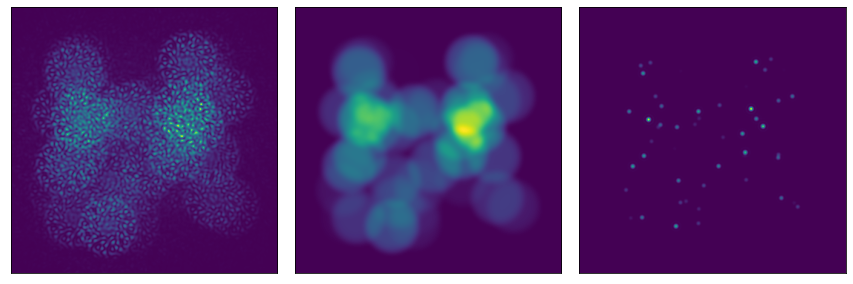

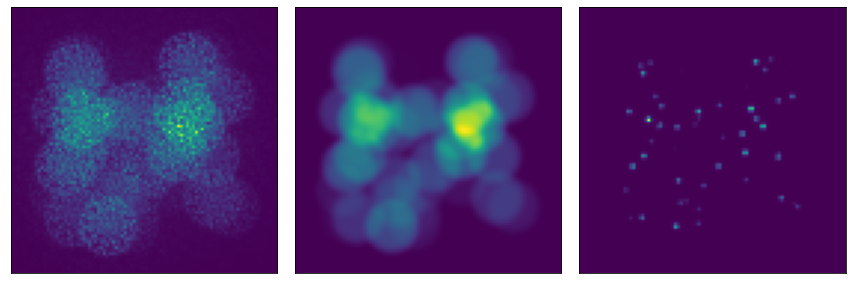

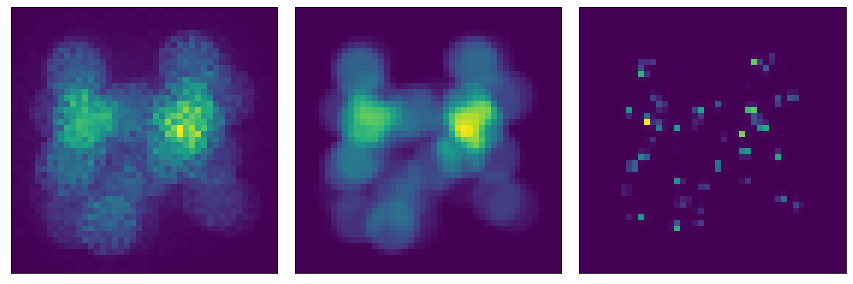

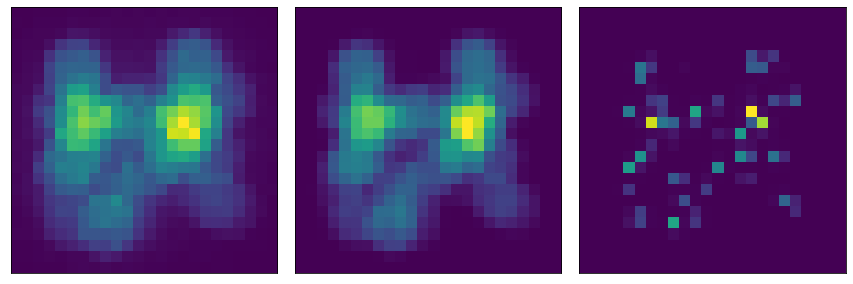

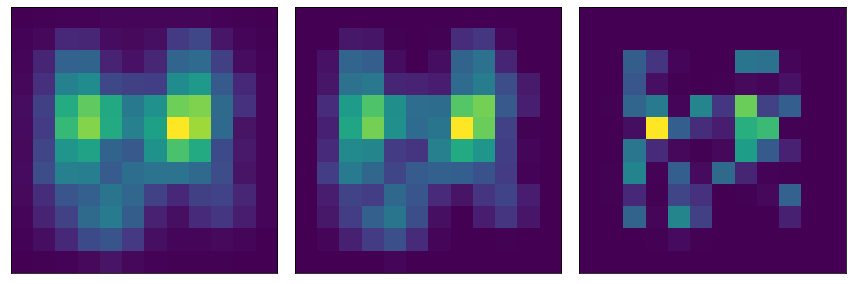

In [67]:
ksizes_test = [1, 4, 8, 15, 30]
for l in range(len(ksizes_test)):
    for k in tqdm(range(len(all_args))):
    # for k in tqdm(range(1)):
        args_in = all_args[k]
        args_in['ksize'] = ksizes_test[l]
        ksize= args_in['ksize']
        # Generate images
        images = []
        for i in tqdm(range(nims), leave=False):
            PSFs = np.zeros([npix//ksize, npix//ksize])
            for j in tqdm(range(N), leave=False):
                if args_in['pupil'] is None:
                    PSF = fluxes_true[j] * Gaussian(xs_true[j], ys_true[j], args=args_in)
                else:
                    PSF = fluxes_true[j] * JAX_model(xs_true[j], ys_true[j], args=args_in)
                PSFs += PSF

            image = index_update(PSFs, index[PSFs>args_in['well_depth']], args_in['well_depth'])
    #         image = PSFs
    #         image += np.abs(np.round(onp.random.normal(scale=BG_stdev, size=[npix//ksize, npix//ksize])).astype(np.int64))
            images.append(image)

        args_in['image'] = image
        args_in['PSF'] = PSFs
    #     args_in['base_error'] = error(X_true, args=args_in)
    
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(tol_args['image'])
    plt.xticks([])
    plt.yticks([])
    # cb = plt.colorbar()
    # cb.ax.tick_params(labelsize=20)
    # cb.ax.set_ylabel("Flux (Photons)", fontsize=20)

    plt.subplot(1, 3, 2)
    plt.imshow(diff_args['image'])
    plt.xticks([])
    plt.yticks([])
    # cb = plt.colorbar()
    # cb.ax.tick_params(labelsize=20)
    # cb.ax.set_ylabel("Flux (Photons)", fontsize=20)

    plt.subplot(1, 3, 3)
    plt.imshow(airy_args['image'])
    plt.xticks([])
    plt.yticks([])
    # cb = plt.colorbar()
    # cb.ax.tick_params(labelsize=20)
    # cb.ax.set_ylabel("Flux (Photons)", fontsize=20)

    plt.tight_layout()
    plt.savefig("Sub_Nyq_{}".format(ksize))
    plt.show()

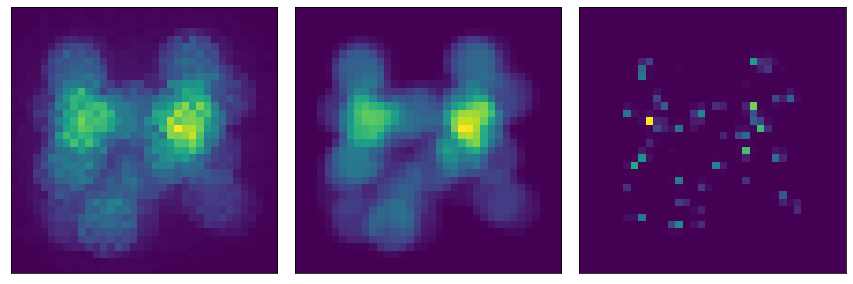

In [63]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(tol_args['image'])
plt.xticks([])
plt.yticks([])
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=20)
# cb.ax.set_ylabel("Flux (Photons)", fontsize=20)

plt.subplot(1, 3, 2)
plt.imshow(diff_args['image'])
plt.xticks([])
plt.yticks([])
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=20)
# cb.ax.set_ylabel("Flux (Photons)", fontsize=20)

plt.subplot(1, 3, 3)
plt.imshow(airy_args['image'])
plt.xticks([])
plt.yticks([])
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=20)
# cb.ax.set_ylabel("Flux (Photons)", fontsize=20)

plt.tight_layout()
plt.savefig("Sub_Nyq_{}".format(ksize))
plt.show()

In [18]:
# # Start vector
# xs_start = xs_true + 1.5*(onp.random.rand(len(xs_true)) - 0.5)
# ys_start = ys_true + 1.5*(onp.random.rand(len(xs_true)) - 0.5)
# fluxes_start = fluxes_true * (1 + (onp.random.rand(len(fluxes_true)) - 0.5)/4)
# BG_start = BG_true
# X_start = np.concatenate([xs_start, ys_start, fluxes_start, BG_start])

# Begin GD

## Toliman

In [19]:
err_grad = value_and_grad(error)

# Testing Values
ith = 500
last = 200
epochs = 500
save = 500
err_check = 25

In [20]:
all_args = [deepcopy(args), deepcopy(args), deepcopy(args)]
pupils = [tol_pupil, None, airy_pupil]
labels = ["Toliman", "Diffuser", "Airy"]

LRs = [np.array([1e-1, 1e6, 1e-2]), # Toliman
       np.array([1e-1, 1e6, 1e-2]), # Diffuser
        np.array([1e-1, 1e6, 1e-2])] # Airy

LR_in = []
for i in range(len(LRs)):
    LR_in.append(np.concatenate([np.ones(2*N)*LRs[i][0], np.ones(N)*LRs[i][1], np.ones(1)*LRs[i][2]]))

---
# Big Loop

In [23]:
seeds = np.arange(3)
ksizes = [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24, 30, 36, 40, 45]

for ksize in tqdm(ksizes):
    args['ksize'] = ksize
    print("Starting\tksize: {}\n".format(ksize))
    for seed in tqdm(seeds, leave=False):
        print("Starting\tseed: {}\n".format(seed))
        # Generate Inputs
        onp.random.seed(seed)
        args['xs_true'] = (0.8*npix) * (onp.random.rand(N) - 0.5)
        args['ys_true'] = (0.8*npix) * (onp.random.rand(N) - 0.5)
        args['fluxes_true'] = np.abs(onp.random.normal(scale=max_flux/2, size=[N]))
        BG_in = np.abs(np.round(onp.random.normal(scale=BG_stdev, size=[npix//ksize, npix//ksize])).astype(np.int64))
        args['BG_true'] = np.array([BG_stdev*((2/np.pi)**0.5)], dtype=np.float64)
        X_true = np.concatenate([args['xs_true'], args['ys_true'], args['fluxes_true'], args['BG_true']])
        np.save("data/X_true_{}.npy".format(seed), X_true)
        args['X_true'] = X_true

        # Start vector
        xs_start = args['xs_true'] + 1.5*(onp.random.rand(len(args['xs_true'])) - 0.5)
        ys_start = args['ys_true'] + 1.5*(onp.random.rand(len(args['xs_true'])) - 0.5)
        fluxes_start = args['fluxes_true'] * (1 + (onp.random.rand(len(args['fluxes_true'])) - 0.5)/4)
        BG_start = args['BG_true']
        X_start = np.concatenate([xs_start, ys_start, fluxes_start, BG_start])

        # Iterate over the pupils
        for k in tqdm(range(3), leave=False):

            if "{}_err_{}_{}_{}.p".format(labels[k], ksize, seed, save) in os.listdir("data/"):
                print("{}     \tksize: {} \tseed: {}\t \tDone".format(labels[k], ksize, seed))
            else:
                print("{}     \tksize: {} \tseed: {}\t \tStarting".format(labels[k], ksize, seed))
                args_in = deepcopy(args)
                args_in['pupil'] = pupils[k]
                args_in['label'] = labels[k]

                # Generate images
                PSFs = np.zeros([npix//ksize, npix//ksize])
                for j in range(N):
                    if args_in['pupil'] is None:
                        PSF = args['fluxes_true'][j] * Gaussian(args['xs_true'][j], args['ys_true'][j], args=args_in)
                    else:
                        PSF = args['fluxes_true'][j] * JAX_model(args['xs_true'][j], args['ys_true'][j], args=args_in)
                    PSFs += PSF
                image = index_update(PSFs, index[PSFs>args_in['well_depth']], args_in['well_depth'])
                image += BG_in
                args_in['image'] = image
                args_in['PSF'] = PSFs
                args_in['base_error'] = error(X_true, args=args_in)

                # Do Gradient Descent
                X = deepcopy(X_start)
                LR = LR_in[k]
                errs = {'err': [],'PPerr_avg': [], 'PPerr': [], 'Ferr': [],'FPerr': [], 'FPerr_avg': [], 'BGerr': []}
                Xs = []
                m, v = 0, 0
                for i in tqdm(range(epochs), leave=False):
                    Xs.append(X)
                    err, grads = err_grad(X, args=args_in)
                    errs = get_errors(errs, X, err, args=args_in)
                    printit(i, Xs, errs, args=args_in, ith=ith, last=last)
                    X, m, v = ADAM(X, grads, LR, i, m, v)
                    # Check to reduce LR
                    if i%err_check == 0 and i >= err_check and err >= np.average(errs['err'][-err_check:]):
                        print("{} - Reducing Learning Rate".format(i))
                        LR *= 0.5 # halve LR

                np.save("data/{}_Xs_{}_{}_{}.npy".format(args_in['label'], ksize, seed, i+1), Xs)
                pickle.dump(errs, open("data/{}_err_{}_{}_{}.p".format(args_in['label'], ksize, seed, i+1), 'wb'))
                print("{}     \tksize: {} \tseed: {}\t \tDone".format(labels[k], ksize, seed))

Starting	ksize: 1



Starting	seed: 0



Toliman     	ksize: 1 	seed: 0	 	Done
Diffuser     	ksize: 1 	seed: 0	 	Done
Airy     	ksize: 1 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 1 	seed: 1	 	Done
Diffuser     	ksize: 1 	seed: 1	 	Done
Airy     	ksize: 1 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 1 	seed: 2	 	Done
Diffuser     	ksize: 1 	seed: 2	 	Done
Airy     	ksize: 1 	seed: 2	 	Done
Starting	ksize: 2



Starting	seed: 0



Toliman     	ksize: 2 	seed: 0	 	Done
Diffuser     	ksize: 2 	seed: 0	 	Done
Airy     	ksize: 2 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 2 	seed: 1	 	Done
Diffuser     	ksize: 2 	seed: 1	 	Done
Airy     	ksize: 2 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 2 	seed: 2	 	Done
Diffuser     	ksize: 2 	seed: 2	 	Done
Airy     	ksize: 2 	seed: 2	 	Done
Starting	ksize: 3



Starting	seed: 0



Toliman     	ksize: 3 	seed: 0	 	Done
Diffuser     	ksize: 3 	seed: 0	 	Done
Airy     	ksize: 3 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 3 	seed: 1	 	Done
Diffuser     	ksize: 3 	seed: 1	 	Done
Airy     	ksize: 3 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 3 	seed: 2	 	Done
Diffuser     	ksize: 3 	seed: 2	 	Done
Airy     	ksize: 3 	seed: 2	 	Done
Starting	ksize: 4



Starting	seed: 0



Toliman     	ksize: 4 	seed: 0	 	Done
Diffuser     	ksize: 4 	seed: 0	 	Done
Airy     	ksize: 4 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 4 	seed: 1	 	Done
Diffuser     	ksize: 4 	seed: 1	 	Done
Airy     	ksize: 4 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 4 	seed: 2	 	Done
Diffuser     	ksize: 4 	seed: 2	 	Done
Airy     	ksize: 4 	seed: 2	 	Done
Starting	ksize: 5



Starting	seed: 0



Toliman     	ksize: 5 	seed: 0	 	Done
Diffuser     	ksize: 5 	seed: 0	 	Done
Airy     	ksize: 5 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 5 	seed: 1	 	Done
Diffuser     	ksize: 5 	seed: 1	 	Done
Airy     	ksize: 5 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 5 	seed: 2	 	Done
Diffuser     	ksize: 5 	seed: 2	 	Done
Airy     	ksize: 5 	seed: 2	 	Done
Starting	ksize: 6



Starting	seed: 0



Toliman     	ksize: 6 	seed: 0	 	Done
Diffuser     	ksize: 6 	seed: 0	 	Done
Airy     	ksize: 6 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 6 	seed: 1	 	Done
Diffuser     	ksize: 6 	seed: 1	 	Done
Airy     	ksize: 6 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 6 	seed: 2	 	Done
Diffuser     	ksize: 6 	seed: 2	 	Done
Airy     	ksize: 6 	seed: 2	 	Done
Starting	ksize: 8



Starting	seed: 0



Toliman     	ksize: 8 	seed: 0	 	Done
Diffuser     	ksize: 8 	seed: 0	 	Done
Airy     	ksize: 8 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 8 	seed: 1	 	Done
Diffuser     	ksize: 8 	seed: 1	 	Done
Airy     	ksize: 8 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 8 	seed: 2	 	Done
Diffuser     	ksize: 8 	seed: 2	 	Done
Airy     	ksize: 8 	seed: 2	 	Done
Starting	ksize: 9



Starting	seed: 0



Toliman     	ksize: 9 	seed: 0	 	Done
Diffuser     	ksize: 9 	seed: 0	 	Done
Airy     	ksize: 9 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 9 	seed: 1	 	Done
Diffuser     	ksize: 9 	seed: 1	 	Done
Airy     	ksize: 9 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 9 	seed: 2	 	Done
Diffuser     	ksize: 9 	seed: 2	 	Done
Airy     	ksize: 9 	seed: 2	 	Done
Starting	ksize: 10



Starting	seed: 0



Toliman     	ksize: 10 	seed: 0	 	Done
Diffuser     	ksize: 10 	seed: 0	 	Done
Airy     	ksize: 10 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 10 	seed: 1	 	Done
Diffuser     	ksize: 10 	seed: 1	 	Done
Airy     	ksize: 10 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 10 	seed: 2	 	Done
Diffuser     	ksize: 10 	seed: 2	 	Done
Airy     	ksize: 10 	seed: 2	 	Done
Starting	ksize: 12



Starting	seed: 0



Toliman     	ksize: 12 	seed: 0	 	Done
Diffuser     	ksize: 12 	seed: 0	 	Done
Airy     	ksize: 12 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 12 	seed: 1	 	Done
Diffuser     	ksize: 12 	seed: 1	 	Done
Airy     	ksize: 12 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 12 	seed: 2	 	Done
Diffuser     	ksize: 12 	seed: 2	 	Done
Airy     	ksize: 12 	seed: 2	 	Done
Starting	ksize: 15



Starting	seed: 0



Toliman     	ksize: 15 	seed: 0	 	Done
Diffuser     	ksize: 15 	seed: 0	 	Done
Airy     	ksize: 15 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 15 	seed: 1	 	Done
Diffuser     	ksize: 15 	seed: 1	 	Done
Airy     	ksize: 15 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 15 	seed: 2	 	Done
Diffuser     	ksize: 15 	seed: 2	 	Done
Airy     	ksize: 15 	seed: 2	 	Done
Starting	ksize: 18



Starting	seed: 0



Toliman     	ksize: 18 	seed: 0	 	Done
Diffuser     	ksize: 18 	seed: 0	 	Done
Airy     	ksize: 18 	seed: 0	 	Done
Starting	seed: 1



Toliman     	ksize: 18 	seed: 1	 	Done
Diffuser     	ksize: 18 	seed: 1	 	Done
Airy     	ksize: 18 	seed: 1	 	Done
Starting	seed: 2



Toliman     	ksize: 18 	seed: 2	 	Done
Diffuser     	ksize: 18 	seed: 2	 	Done
Airy     	ksize: 18 	seed: 2	 	Done
Starting	ksize: 20



Starting	seed: 0



Toliman     	ksize: 20 	seed: 0	 	Starting


KeyboardInterrupt: 

---

In [ ]:
# LRs = np.array([5e-2, 1e5, 1e-2]) # Position, Flux, Background
# LR = np.concatenate([np.ones(2*N)*LRs[0], np.ones(N)*LRs[1], np.ones(1)*LRs[2]])
# X = deepcopy(X_start)
# args_in = tol_args

# # Perform grad descent
# errs = {'err': [],'PPerr_avg': [], 'PPerr': [], 'Ferr': [],'FPerr': [], 'FPerr_avg': [], 'BGerr': []}
# Xs = []
# m, v = 0, 0
# for i in tqdm(range(epochs)):
#     err, grads = err_grad(X, args=args_in)
    
#     # Save values
#     Xs.append(X)
#     errs = get_errors(errs, X, err, args=args_in)
#     printit(i, Xs, errs, args=args_in, ith=ith, last=last)
    
#     # Check to reduce LR
#     if i%err_check == 0 and i >= err_check and errs['err'][-err_check] < err:
#         print("Reducing Learning Rate")
#         LR *= 0.5 # halve LR
        
#     if (i+1)%save == 0:
#         np.save("data/{}_Xs_{}_{}_{}.npy".format(args_in['label'], ksize, seed, i+1), Xs)
#         pickle.dump(errs, open("data/{}_err_{}_{}_{}.p".format(args_in['label'], ksize, seed, i+1), 'wb'))
        
#     X, m, v = ADAM(X, grads, LR, i, m, v)

In [ ]:
# args_in = tol_args
# epoch = 2500
# Xs = list(np.load("{}_Xs_{}_{}_{}.npy".format(args_in['label'], ksize, seed, epoch)))
# errs = pickle.load(open("{}_err_{}_{}_{}.p".format(args_in['label'], ksize, seed, epochs), 'rb'))
# printit(epoch-1, Xs, errs, args=args_in, ith=ith, last=last)

## Diffuser

In [ ]:
# # LRs = np.array([5e-2, 1e5, 1e-2]) # Position, Flux, Background
# LRs = np.array([2e-2, 5e4, 1e-2]) # Position, Flux, Background
# LR = np.concatenate([np.ones(2*N)*LRs[0], np.ones(N)*LRs[1], np.ones(1)*LRs[2]])
# X = deepcopy(X_start)
# args_in = diff_args

# # Perform grad descent
# errs = {'err': [],'PPerr_avg': [], 'PPerr': [], 'Ferr': [],'FPerr': [], 'FPerr_avg': [], 'BGerr': []}
# Xs = []
# m, v = 0, 0
# for i in tqdm(range(epochs)):
#     err, grads = err_grad(X, args=args_in)
    
#     # Save values
#     Xs.append(X)
#     errs = get_errors(errs, X, err, args=args_in)
#     printit(i, Xs, errs, args=args_in, ith=ith, last=last)
    
#     # Check to reduce LR
#     if i%err_check == 0 and i >= err_check and errs['err'][-err_check] < err:
#         print("Reducing Learning Rate")
#         LR *= 0.5 # halve LR
        
#     if (i+1)%save == 0:
#         np.save("data/{}_Xs_{}_{}_{}.npy".format(args_in['label'], ksize, seed, i+1), Xs)
#         pickle.dump(errs, open("data/{}_err_{}_{}_{}.p".format(args_in['label'], ksize, seed, i+1), 'wb'))
        
#     X, m, v = ADAM(X, grads, LR, i, m, v)

In [ ]:
# for i in tqdm(range(epochs, 2*epochs)):
#     err, grads = err_grad(X, args=args_in)
    
#     # Save values
#     Xs.append(X)
#     errs = get_errors(errs, X, err, args=args_in)
#     printit(i, Xs, errs, args=args_in, ith=ith, last=last)
    
#     # Check to reduce LR
#     if i%err_check == 0 and i >= err_check and errs['err'][-err_check] < err:
#         print("Reducing Learning Rate")
#         LR *= 0.5 # halve LR
        
#     if (i+1)%save == 0:
#         np.save("{}_Xs_{}_{}_{}.npy".format(args_in['label'], ksize, seed, i+1), Xs)
#         pickle.dump(errs, open("{}_err_{}_{}_{}.p".format(args_in['label'], ksize, seed, i+1), 'wb'))
        
#     X, m, v = ADAM(X, grads, LR, i, m, v)

In [ ]:
# args_in = diff_args
# epoch = 1000
# Xs = list(np.load("{}_Xs_{}_{}_{}.npy".format(args_in['label'], ksize, seed, epoch)))
# errs = pickle.load(open("{}_err_{}_{}_{}.p".format(args_in['label'], ksize, seed, epoch), 'rb'))
# X = deepcopy(Xs[-1])

# LRs = np.array([2e-2, 5e4, 1e-2]) # Position, Flux, Background
# LR = np.concatenate([np.ones(2*N)*LRs[0], np.ones(N)*LRs[1], np.ones(1)*LRs[2]])

# printit(epoch-1, Xs, errs, args=args_in, ith=ith, last=last)

# for i in tqdm(range(epoch, epochs)):
#     err, grads = err_grad(X, args=args_in)

#     # Save values
#     Xs.append(X)
#     errs = get_errors(errs, X, err, args=args_in)
#     printit(i, Xs, errs, args=args_in, ith=ith, last=last)
    
#     # Check to reduce LR
#     if i%err_check == 0 and i >= err_check and errs['err'][-err_check] < err:
#         print("Reducing Learning Rate")
#         LR *= 0.5 # halve LR

#     # Take step
#     step = grads*LR
#     X -= step
    
#     if (i+1)%save == 0:
#         np.save("{}_Xs_{}_{}.npy".format(args_in['label'], seed, i+1), Xs)
#         pickle.dump(errs, open("{}_err_{}_{}.p".format(args_in['label'], seed, i+1), 'wb'))

# print("Done")

## Airy

In [ ]:
# # LRs = np.array([5e-9, 1e-1, 1e-6]) # Position, Flux, Background
# LRs = np.array([2e-5, 5e2, 1e-2]) # Position, Flux, Background
# LR = np.concatenate([np.ones(2*N)*LRs[0], np.ones(N)*LRs[1], np.ones(1)*LRs[2]])
# X = deepcopy(X_start)
# args_in = airy_args

# # Perform grad descent
# errs = {'err': [],'PPerr_avg': [], 'PPerr': [], 'Ferr': [], 'FPerr': [], 'FPerr_avg': [], 'BGerr': []}
# Xs = []
# for i in tqdm(range(epochs)):
#     err, grads = err_grad(X, args=args_in)

#     # Save values
#     Xs.append(X)
#     errs = get_errors(errs, X, err, args=args_in)
#     printit(i, Xs, errs, args=args_in, ith=ith, last=last)
    
#     # Check to reduce LR
#     if i%err_check == 0 and i >= err_check and errs['err'][-err_check] < err:
#         print("Reducing Learning Rate")
#         LR *= 0.5 # halve LR

#     # Take step
#     step = grads*LR
#     X -= step

#     if (i+1)%save == 0:
#         np.save("{}_Xs_{}_{}_{}.npy".format(args_in['label'], ksize, seed, i+1), Xs)
#         pickle.dump(errs, open("{}_err_{}_{}_{}.p".format(args_in['label'], ksize, seed, i+1), 'wb'))
    
# print("Done")